In [1]:
# Script creates custom environment and runs within the RLlib framework

import pandas as pd
import yfinance as yf
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding

import matplotlib
import matplotlib.pyplot as plt
import datetime

import os

In [2]:
class DataSimulator():
    '''
    Simulate fake data for sanity check of deep reinforcement learning algorithms and environments.
    
    Parameters
    ----------
    SO : float, default=100
        Initial stock price
    mu : float, defaul=0.02
        Average return
    sigma : float, default=0.05
        Standatd deviation (volatility)
    N : int, default=5
        Number of stocks/simulated trajectiories
    days : int, default=252
        Length of simulated trajectiories
    plot : bool, default=True 
        Plot simulated data.
    name_prefix: str, defalult='fake'
        Name prefix for specific simulated series.
    '''
    def __init__(self, S0=100., mu=0.02, sigma=0.05, N=5, days=252*1, plot=True, name_prefix='fake'):
        self.S0 = S0
        self.mu = mu
        self.sigma = sigma
        self.N = N
        self.days = days
        self.T = 1
        self.dt = self.T / self.days
        self.plot = plot
        self.name_prefix = name_prefix

        self.S, self.names = self.simulate_dummies()

    def simulate_dummies(self):
        S = np.zeros((self.days+1, self.N))
        S[0] = self.S0

        for t in range(1, self.days+1):
            W = np.random.normal(size=self.N) # random part of the stochastic equation (wiener process)
            S[t] = S[t-1] * np.exp((self.mu - 0.5 * self.sigma**2) * self.dt + self.sigma * np.sqrt(self.dt) * W) # St = S0exp()

        if self.plot:
            plt.figure(figsize=(15, 10))
            plt.plot(S)
            plt.show()

        captions = [ f'{self.name_prefix}_{i+1}' for i in range(self.N)]

        return S, captions

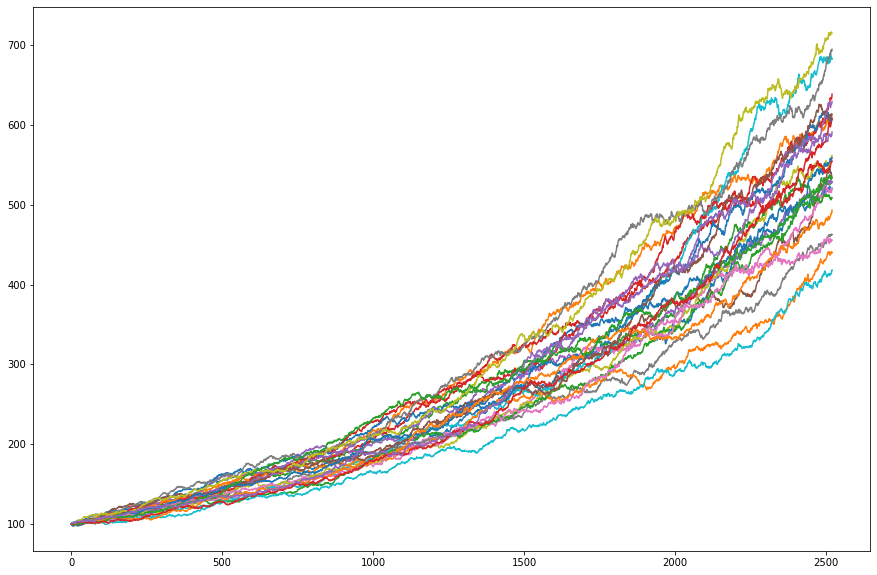

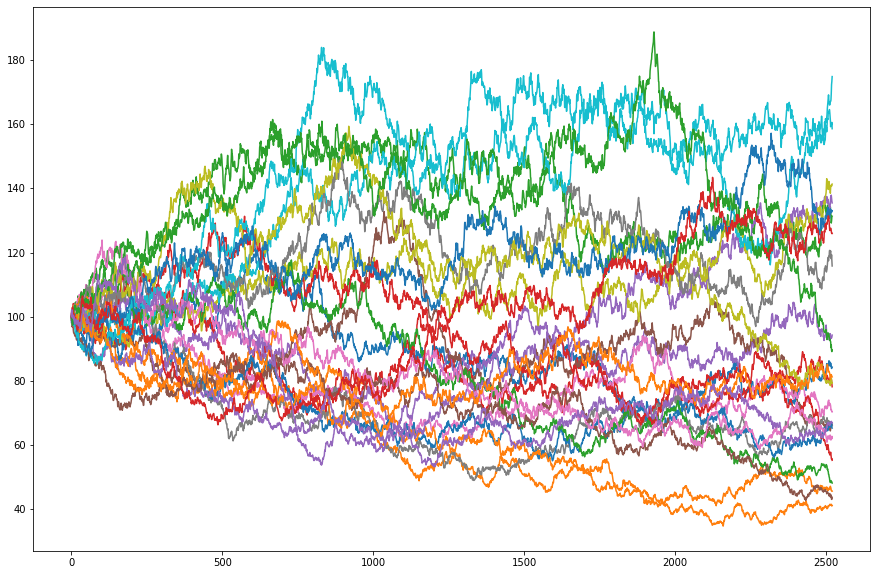

In [3]:
data = DataSimulator(mu=1.75, sigma=0.17, N=25, days=252*10)
data2 = DataSimulator(mu=-0.1, sigma=0.42, N=25, days=252*10)

In [4]:
class StockPickerEnv(gym.Env):
    def __init__(self,
                sanity_check_mode=True, 
                tickers=['ES=F', 'IBM', 'VOW.DE', 'VRTX'],
                N=3,
                initial_amount=100000, 
                mkt_position_thresholds=(0,2), 
                leverage_threshold=2):
        # Atributes
        self.sanity_check_mode = sanity_check_mode
        self.tickers = tickers
        self.N = N # dummy stocks 'good' and 'bad'
        self.df = self._get_data()
        self.initial_amount = initial_amount
        self.n_stocks = 0
        self.index = 0
        self.transactions_cost_pct = 0.0015
        self.portfolio_value = self.initial_amount
        self.done = False
        self.features_list = ['Close']
        self.mkt_position_thresholds = mkt_position_thresholds
        self.leverage_threshold = leverage_threshold
        self.total_market_position = 0
        self.leverage = 1
        self.action_number = len(self.tickers) + 2 * self.N # N is for dummy stocks: 2* because stocks are 'good' and 'bad'
        
        # Acton-State space
        self.action_space = spaces.Dict({
                            "total_market_position": spaces.Box(low=0, high=2, shape=()),
                            "leverage": spaces.Box(low=1, high=2, shape=()),
                            "orders": spaces.MultiDiscrete([3]*self.action_number) # 1: Buy, -1: Sell, 0: Nothing
                            })
        self.observation_space = spaces.Dict({
                                    #"features": spaces.Box(low=-np.inf, high=np.inf, shape=(len(self.df.Symbol.unique()), )),  #len(self.df.columns)-2
                                    "features": spaces.Box(low=-np.inf, high=np.inf, shape=(10, )),
                                    "n_stocks":spaces.Discrete(15)
                            })
        
        # Memory Buffer
        self.reward_memory = [0] 
        self.actions_memory = len(self.df.Symbol.unique()) * [0] # no actions at the beginning
        self.date_memory =  [self.df.Date.unique()[0]] # first date where the action and reward is nothing       

    def step(self, action):
        n_longs = len([ x for x in action['orders'] if x > 0 ])
        n_shorts = len([ x for x in action['orders'] if x < 0 ])
        self.n_stocks = len([ x for x in action['orders'] if x != 0 ]) # beacause of gym.spaces.Discrete()
        
        self.total_market_position = action['total_market_position']
        self.leverage = action['leverage']
        
        # Load next state (data for next day)
        self.index += 1
        previous_day_data = self.df[self.df.Date==self.df.Date.unique()[self.index-1]]
        current_day_data = self.df[self.df.Date==self.df.Date.unique()[self.index]]
        features_data = current_day_data[self.features_list].values.flatten()
        
        self.state = { "features": features_data,
                        "n_stocks": self.n_stocks
                    }
        
        # incoming parameter "action" brings i.a. list of orders (as actuall picks)
        picks_ = []
        actionMapper = {
            0:0,
            1:1,
            2:-1
        }
        [ picks_.append(actionMapper[pick]) for pick in action['orders'] ]
        '''
        if n_shorts != n_longs: #or self.n_stocks < 5 or self.n_stocks > 15 or self.leverage < self.total_market_position:
            reward = -10000
        else:
        '''
        ### Capital allocation ###
        # Array with allocations -- portfolio items values at the start of the trading period
        long_weight, short_weight = self._get_weights()
        nav_per_long = long_weight * self.portfolio_value
        nav_per_short = short_weight * self.portfolio_value
        allocations = np.array(picks_)
        allocations = np.where(allocations > 0, allocations*nav_per_long, allocations)
        allocations = np.where(allocations < 0, allocations*nav_per_short, allocations)
        # Calculation of results for specific time period -- return rate, profit, new portfolio values
        change_rate = current_day_data.Close.values / previous_day_data.Close.values
        rewards = change_rate * allocations - allocations # aka profit for each asset
        reward = np.sum(rewards)
        
        self.reward_memory.append(reward)
        #profit_rate = reward / self.portfolio_value
        self.portfolio_value += reward

        self.done = bool(self.index >= len(self.df.Date.unique()) - 2) # explanation: e.g. length is 100 => 100 - 1 to receive correct index value and 99 - 1 to switch done = True before the last step (else in the next step the index is out of range). In other words, action is taken at the penultimate step, ultimate step i terminal
        
        if self.done:
            daily_returns = pd.DataFrame(self.reward_memory)
            daily_returns.columns = ["Daily_return"]
            plt.plot(daily_returns.Daily_return.cumsum(), 'r')
            plt.savefig('results*cumulative.png')
            plt.close()

            plt.plot(self.portfolio_value, 'r')
            plt.savefig('results/portfolio_value.png')
            plt.close()

            print("====================================")
            print(f"end_total_asset: {self.portfolio_value}")

            print(f'reward memory: {self.reward_memory}')
            if daily_returns['Daily_return'].std() != 0:
                sharpe = (252**0.5) * daily_returns['Daily_return'].mean() / daily_returns['Daily_return'].std()
                print(f'sharpe: {sharpe}')

        return self.state, self.reward_memory[-1], self.done, {'Terminal step': self.done}
    
    def _get_data(self, start='2010-01-01'):
        '''
        Price data download. 
        If self.sanity_check is True, the method simulates "good" and "bad" stocks and add them to the outcoming dataframe.
        Simulated data serves as a sanity check for data mining and optimization algorithms (one can intuitively see whether the algos work).
        '''    
        #df = yf.download(['^GSPC', 'BTC-USD', 'IBM', 'VOW.DE'], start=start)
        df = yf.download(self.tickers, start=start)
        df = df.Close
        #print(df.tail())
        df = df.dropna().reset_index()
        df['Date'] = df['Date'].astype(str)
        df = df.melt(id_vars=['Date'], var_name='Symbol', value_name='Close')

        if self.sanity_check_mode:
            good_data = DataSimulator(mu=0.18, sigma=0.04, N=self.N, days=len(df.Date.unique())-1, name_prefix='good_stock')
            good_df = pd.DataFrame(data=good_data.S, columns=good_data.names)
            good_df['Date'] = df.Date.unique()
            good_df = good_df.melt(id_vars=['Date'], var_name='Symbol', value_name='Close')

            bad_data = DataSimulator(mu=-0.02, sigma=0.35, N=self.N, days=len(df.Date.unique())-1, name_prefix='bad_stock')
            bad_df = pd.DataFrame(data=bad_data.S, columns=bad_data.names)
            bad_df['Date'] = df.Date.unique()
            bad_df = bad_df.melt(id_vars=['Date'], var_name='Symbol', value_name='Close')

            df = pd.concat(objs=[df, good_df, bad_df], axis='index')
            df = df.reset_index(drop=True) # duplicity in index

        print(len(df.Symbol.unique()))
        return df
    
    def _get_weights(self):
        '''
        The method returns weight number for both long and short position. 
        There is an assumption that all longs (shorts) are equally weighted (warning: simultaneously longs != shorts).
        
        Relationship between 'leverage' and 'market exposition' :
        ---------------------------------------------------------
        leverage = |longs| + |shorts|
        market_exposition = longs + shorts

        One can infer 'long' and 'short' position to keep both requirements.
        '''
        if self.total_market_position < self.mkt_position_thresholds[0] or self.total_market_position > self.mkt_position_thresholds[1]:
            raise ValueError(f"Market position exceeds thresholds: {self.total_market_position} is out of the bounds {self.mkt_position_thresholds}")
        elif self.leverage < 1 or self.leverage > self.leverage_threshold:
            raise ValueError(f"Financial leverage: {self.leverage} is out of the bounds: 1, {self.leverage_threshold}")
        
        long = (self.leverage + self.total_market_position) / 2
        short = self.total_market_position - long
        long_weight = long / (self.n_stocks/2) # long share divided by number of stocks on long side (long/(n_stock/2)) 
        short_weight = short / (self.n_stocks/2) # the same but for the short side

        return long_weight, short_weight               

    def reset(self):
        self.index = 0
        self.done = False
        self.n_stocks = 0
        self.portfolio_value = self.initial_amount
        self.total_market_position = 0
        self.leverage = 0

        self.reward_memory = [0]
        self.actions_memory = len(self.df.Symbol.unique()) * [0]
        self.date_memory = [self.df.Date.unique()[0]]

        # Initial state
        features_data = self.df[self.df.Date==self.df.Date.unique()[self.index]][self.features_list].values.flatten()
        print(features_data.shape)
        self.state = { "features": features_data,
                        "n_stocks": self.n_stocks
        }

        return self.state


[*********************100%***********************]  4 of 4 completed


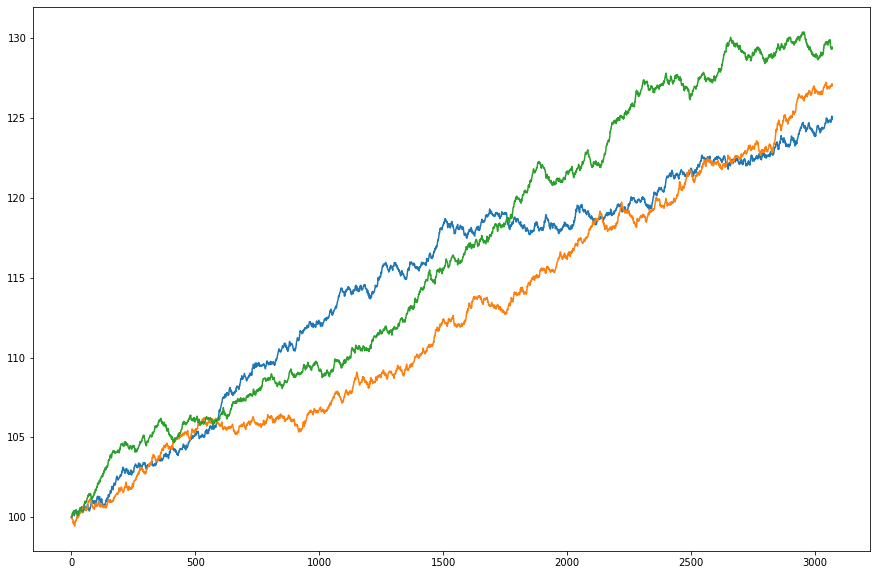

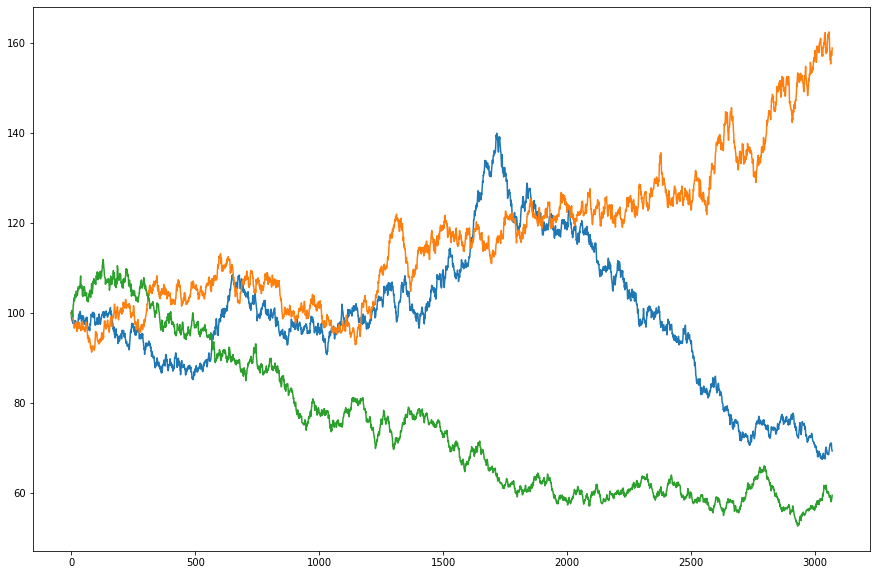

10
0
(10,)
{'features': array([1128.75      ,  126.62523651,   73.75      ,   44.24000168,
        100.        ,  100.        ,  100.        ,  100.        ,
        100.        ,  100.        ]), 'n_stocks': 0}


In [5]:
env = StockPickerEnv()
action = env.action_space.sample()
print(env.n_stocks)
print(env.reset())

In [26]:
for i in range(10):
    action = env.action_space.sample()
    print(env.step(action))

({'features': array([1111.        ,  123.3269577 ,   71.11000061,   39.84999847,
         99.78163458,  100.08767318,   99.93162051,   95.44009787,
         97.19454264,   99.93380822]), 'n_stocks': 5}, -1191.8546127397049, False, {'Terminal step': False})
({'features': array([1091.        ,  119.98088074,   69.55000305,   40.13999939,
         99.87790681,  100.07742857,   99.93010863,   95.76378559,
         96.71123284,   99.6172302 ]), 'n_stocks': 6}, 117.53625953534356, False, {'Terminal step': False})
({'features': array([1092.5       ,  120.57361603,   68.19999695,   39.52000046,
         99.96312736,  100.08555042,   99.76331158,   95.41153897,
         97.3509031 ,   98.39456913]), 'n_stocks': 2}, -1258.3617380345677, False, {'Terminal step': False})
({'features': array([1087.25      ,  120.21988678,   67.90000153,   39.02000046,
        100.01103157,  100.13244848,   99.76637559,   95.31679736,
         97.62899559,   97.91352568]), 'n_stocks': 5}, -356.52096443194887, False,

In [33]:
'''
bool(or n_shorts != n_longs # number of shrots has to be equal to number of blongs
    or n_shorts < 1 # 1 stock in portfolio at minimum
    or n_shorts < self.max_stocks # number of stocks in portfolio should not exceed specific number
    or self.leverage < self.total_market_position) # short positions must be always negative (otherwise you will buy it)        
'''
max_stocks = 4
def check_denied_action(action):    
     return bool(len([ x for x in action['orders'] if x != 0 ]) == 0 or
                len([ x for x in action['orders'] if x == 1 ]) != len([ x for x in action['orders'] if x == 2]) or
                len([ x for x in action['orders'] if x != 0 ]) > max_stocks
                )

In [34]:
action = env.action_space.sample()
while check_denied_action(action):
    #print(action['orders'])
    action = env.action_space.sample()
    check_denied_action(action)

print(f'...choosen action: {action["orders"]}')

...choosen action: [0 1 0 0 0 0 2 0 1 2]


In [38]:
[ f'{action["orders"][i]} for i: {i}' for i in range(len(action['orders'])) ]

['0 for i: 0',
 '1 for i: 1',
 '0 for i: 2',
 '0 for i: 3',
 '0 for i: 4',
 '0 for i: 5',
 '2 for i: 6',
 '0 for i: 7',
 '1 for i: 8',
 '2 for i: 9']

In [40]:
env.df.Symbol.unique().tolist()

['ES=F',
 'IBM',
 'VOW.DE',
 'VRTX',
 'good_stock_1',
 'good_stock_2',
 'good_stock_3',
 'bad_stock_1',
 'bad_stock_2',
 'bad_stock_3']

In [12]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

#%matplotlib inline
from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
#from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.drl_agents.rllib.models import DRLAgent
#from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [13]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [14]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [15]:
# from config.py end_date is a string
config.END_DATE

'2021-10-31'

In [16]:
print(config.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [17]:
config.DOW_30_TICKER

['AXP',
 'AMGN',
 'AAPL',
 'BA',
 'CAT',
 'CSCO',
 'CVX',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'KO',
 'JPM',
 'MCD',
 'MMM',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'TRV',
 'UNH',
 'CRM',
 'VZ',
 'V',
 'WBA',
 'WMT',
 'DIS',
 'DOW']

In [18]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-10-31',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [19]:
df.describe
display(df.columns)

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day'], dtype='object')

In [20]:
display(df["tic"].unique())
display(len(df["tic"].unique()))

array(['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS',
       'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM',
       'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT',
       'DOW'], dtype=object)

30

In [32]:
df.sort_values(["date", "tic"], ignore_index=True).tail()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,cov_list_x,return_list_x,cov_list_y,return_list_y
79049,2021-10-28,453.000000,457.899994,452.519989,452.619965,1672600,UNH,3,12.284832,465.448666,372.239173,65.634248,152.267867,49.416010,413.858812,413.456700,16.530001,75.497949,"[[0.0002727968984801272, 5.279343399208509e-05...",tic AAPL AMGN AXP ... ...,"[[0.0002727968984801272, 5.279343399208509e-05...",tic AAPL AMGN AXP ... ...
79050,2021-10-28,219.250000,219.990005,209.009995,209.130997,23199400,V,3,-1.433043,238.431205,214.330839,38.883883,-230.436611,39.056869,225.641029,227.921691,16.530001,75.497949,"[[0.0002727968984801272, 5.279343399208509e-05...",tic AAPL AMGN AXP ... ...,"[[0.0002727968984801272, 5.279343399208509e-05...",tic AAPL AMGN AXP ... ...
79051,2021-10-28,52.750000,53.150002,52.619999,51.543800,18374700,VZ,3,-0.220244,53.223378,49.937764,45.589415,-39.086009,8.504850,51.831031,52.499389,16.530001,75.497949,"[[0.0002727968984801272, 5.279343399208509e-05...",tic AAPL AMGN AXP ... ...,"[[0.0002727968984801272, 5.279343399208509e-05...",tic AAPL AMGN AXP ... ...
79052,2021-10-28,47.080002,47.349998,46.660000,46.183468,4843900,WBA,3,-0.109992,49.091765,44.961704,46.118051,-103.316679,0.268701,47.153224,47.612535,16.530001,75.497949,"[[0.0002727968984801272, 5.279343399208509e-05...",tic AAPL AMGN AXP ... ...,"[[0.0002727968984801272, 5.279343399208509e-05...",tic AAPL AMGN AXP ... ...
79053,2021-10-28,148.339996,148.979996,147.710007,146.751587,4199500,WMT,3,1.672791,150.024174,131.312832,58.370529,125.657034,30.006323,140.626490,143.343796,16.530001,75.497949,"[[0.0002727968984801272, 5.279343399208509e-05...",tic AAPL AMGN AXP ... ...,"[[0.0002727968984801272, 5.279343399208509e-05...",tic AAPL AMGN AXP ... ...


In [42]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list=config.TECHNICAL_INDICATORS_LIST,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature=False
                    )
df = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2473, 8)
Successfully added vix
Successfully added turbulence index


In [43]:
# Add covariance matrix as STATES
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0] # df --> tuple (factorize()) --> strip inner nupy array ([0])

cov_list = []
return_list = []

# look back is one year: ???: Why we use covariance matrix at all?
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i-lookback:i, :] # i=252: 252-252 => :0, i=253: 1:253, i=254: 2:254 ... rolling and floating window with length 252 elements
    price_lookback = data_lookback.pivot_table(index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna() # percentual change (not logarithmic)
    price_lookback
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)

df_cov = pd.DataFrame({'date':df.date.unique()[lookback:], 'cov_list': cov_list, 'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)

In [44]:
df.head()

,date,open,high,low,close,volume,tic,day,macd_x,boll_ub_x,boll_lb_x,rsi_30_x,cci_30_x,dx_30_x,close_30_sma_x,close_60_sma_x,vix_x,turbulence_x,cov_list_x,return_list_x,cov_list_y,return_list_y,macd_y,boll_ub_y,boll_lb_y,rsi_30_y,cci_30_y,dx_30_y,close_30_sma_y,close_60_sma_y,vix_y,turbulence_y,cov_list_x,return_list_x,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,cov_list_y,return_list_y
0,2013-01-03,19.567142,19.631071,19.321428,16.700764,352965200,AAPL,3,-0.268873,17.034636,15.529513,45.938693,-2.438525,5.042119,16.798558,17.557410,14.56,39.158129,"[[0.0003464058743826651, 5.6458481737101863e-0...",tic AAPL AMGN AXP ... ...,"[[0.0003464058743826651, 5.6458481737101863e-0...",tic AAPL AMGN AXP ... ...,-0.268873,17.034636,15.529513,45.938693,-2.438525,5.042119,16.798558,17.557410,14.56,39.158129,"[[0.0003464058743826651, 5.6458481737101863e-0...",tic AAPL AMGN AXP ... ...,-0.268873,17.034636,15.529513,45.937775,-2.438525,5.042120,16.798558,17.557410,14.56,0.0,"[[0.0003464058743826651, 5.6458481737101863e-0...",tic AAPL AMGN AXP ... ...
1,2013-01-03,89.529999,89.580002,88.339996,69.949265,3871300,AMGN,3,0.003843,71.919958,67.564023,54.734071,49.501197,10.354113,69.557621,68.727064,14.56,39.158129,"[[0.0003464058743826651, 5.6458481737101863e-0...",tic AAPL AMGN AXP ... ...,"[[0.0003464058743826651, 5.6458481737101863e-0...",tic AAPL AMGN AXP ... ...,0.003843,71.919958,67.564023,54.734071,49.501197,10.354113,69.557621,68.727064,14.56,39.158129,"[[0.0003464058743826651, 5.6458481737101863e-0...",tic AAPL AMGN AXP ... ...,0.003843,71.919958,67.564023,54.732221,49.501197,10.354111,69.557621,68.727064,14.56,0.0,"[[0.0003464058743826651, 5.6458481737101863e-0...",tic AAPL AMGN AXP ... ...
2,2013-01-03,58.799999,59.259998,58.630001,51.677814,5017000,AXP,3,0.454979,51.364436,48.626466,57.715903,197.547941,11.154878,49.554792,49.445089,14.56,39.158129,"[[0.0003464058743826651, 5.6458481737101863e-0...",tic AAPL AMGN AXP ... ...,"[[0.0003464058743826651, 5.6458481737101863e-0...",tic AAPL AMGN AXP ... ...,0.454979,51.364436,48.626466,57.715903,197.547941,11.154878,49.554792,49.445089,14.56,39.158129,"[[0.0003464058743826651, 5.6458481737101863e-0...",tic AAPL AMGN AXP ... ...,0.454979,51.364436,48.626466,57.718341,197.547941,11.154879,49.554792,49.445089,14.56,0.0,"[[0.0003464058743826651, 5.6458481737101863e-0...",tic AAPL AMGN AXP ... ...
3,2013-01-03,76.989998,77.980003,76.370003,64.919067,3987000,BA,3,0.693746,64.842758,61.535273,61.231870,178.597702,17.569797,62.761501,61.346905,14.56,39.158129,"[[0.0003464058743826651, 5.6458481737101863e-0...",tic AAPL AMGN AXP ... ...,"[[0.0003464058743826651, 5.6458481737101863e-0...",tic AAPL AMGN AXP ... ...,0.693746,64.842758,61.535273,61.231870,178.597702,17.569797,62.761501,61.346905,14.56,39.158129,"[[0.0003464058743826651, 5.6458481737101863e-0...",tic AAPL AMGN AXP ... ...,0.693746,64.842758,61.535273,61.232966,178.597702,17.569796,62.761501,61.346905,14.56,0.0,"[[0.0003464058743826651, 5.6458481737101863e-0...",tic AAPL AMGN AXP ... ...
4,2013-01-03,93.220001,94.989998,92.889999,72.527405,9329000,CAT,3,1.277519,71.545995,64.368685,63.253825,214.942451,37.866553,66.803035,65.575200,14.56,39.158129,"[[0.0003464058743826651, 5.6458481737101863e-0...",tic AAPL AMGN AXP ... ...,"[[0.0003464058743826651, 5.6458481737101863e-0...",tic AAPL AMGN AXP ... ...,1.277519,71.545995,64.368685,63.253825,214.942451,37.866553,66.803035,65.575200,14.56,39.158129,"[[0.0003464058743826651, 5.6458481737101863e-0...",tic AAPL AMGN AXP ... ...,1.277519,71.545995,64.368685,63.258133,214.942451,37.866555,66.803035,65.575200,14.56,0.0,"[[0.0003464058743826651, 5.6458481737101863e-0...",tic AAPL AMGN AXP ... ...


### Train-Test Data Split

In [45]:
# Because of the stochastic nature of the environment, the task is modeled as a Markov Decision Problem.
# Features, Prices, Positions, Equity ==> States and Environment
# Buy, Sell, Hold are Actions, they can be represented as [-1, 0, 1], {-k, ..., 0, ..., k}
train = data_split(df, "2009-01-01", "2020-07-01")
trade = data_split(df, "2020-07-01", config.END_DATE)
print(len(train))
print(len(trade))

54694
9686


### Environment for Portfolio Allocation

In [46]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.position = 0

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1 
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [2]:
from gym import spaces

def _get_weights(total_market_exposition, leverage, n_stocks, market_expo_thresholds=(0,2), leverage_threshold=2) -> tuple:

    if total_market_exposition < market_expo_thresholds[0] or total_market_exposition > market_expo_thresholds[1]:
        raise ValueError(f'Market exposition exceeds thresholds: {total_market_exposition} is out of bounds {market_expo_thresholds}')
    elif leverage < 1 or leverage > leverage_threshold:
        raise ValueError(f'Financial leverage: {leverage} is out of the bounds: 1, {leverage_threshold}')

    long = (leverage + total_market_exposition) / 2
    short = total_market_exposition - long
    print(long, short)
    long_weights = [ long / (n_stocks/2) ] * int(n_stocks/2) # long share divided by number of stocks on long side (long/(n_stock/2)) multiplied to receive an array of the long weights
    short_weights = [ short / (n_stocks/2)] * int(n_stocks/2) # the same but for the short side
    print(long_weights)
    print(short_weights)

    return long_weights, short_weights

# Sample Step
stocks = ['AAPL', 'MSFT', 'AMZN', 'F', 'FB', "SBX", "OXY", "VRTX", "MCB", "BA"]
stock_dim = len(stocks)
max_stocks = 4 # constraint of number of stocks on the one side (long or short, number of both side is equal)

done = False

while not done:

    actions = spaces.Dict({"total_market_position": spaces.Box(low=0, high=2, shape=(1,)),
                        "leverage": spaces.Box(low=1, high=2, shape=(1,)),
                        "orders": spaces.MultiDiscrete([3]*len(stocks))})    
    
    sample_actions = actions.sample()

    longs = []
    shorts = []

    mapper = {
        0:0,
        1:1,
        2:-1
    }

    orders = []
    [ orders.append(mapper[action]) for action in sample_actions["orders"] ]
    print(orders)
    total_market_position = sample_actions["total_market_position"][0]
    leverage = sample_actions["leverage"][0]
    n_stocks = len([ x for x in orders if x != 0])
    #print(f'Number of stocks: {n_stocks}')
    n_longs = len([ longs.append(x) for x in orders if x > 0 ])
    n_shorts = len([ shorts.append(x) for x in orders if x < 0 ])

    longs_weights, short_weights = _get_weights(total_market_position, leverage, n_stocks)

    done = bool(
        n_shorts == n_longs
        and n_shorts > 1 
        and n_shorts < max_stocks 
        and leverage > total_market_position)

    print(done)

print(f'Number of stocks: {n_stocks}')
print(orders)
print(f'Long Weights: {longs_weights}, Short Weights: {short_weights}')
print(f'Market Position: {total_market_position}')
print(f'Leverage: {leverage}')

[-1, 0, -1, 0, 0, 1, 1, -1, 1, -1]
1.424720048904419 0.1738070249557495
[0.4070628711155483, 0.4070628711155483, 0.4070628711155483]
[0.049659149987357, 0.049659149987357, 0.049659149987357]
False
[-1, 1, 1, 0, -1, -1, 0, 0, 0, 0]
0.9322269558906555 -0.41706210374832153
[0.3728907823562622, 0.3728907823562622]
[-0.1668248414993286, -0.1668248414993286]
False
[0, -1, -1, 0, 1, 1, -1, 0, 0, -1]
0.9186193346977234 -0.2848474383354187
[0.30620644489924115, 0.30620644489924115, 0.30620644489924115]
[-0.09494914611180623, -0.09494914611180623, -0.09494914611180623]
False
[0, 1, 0, 0, -1, 1, -1, -1, -1, 0]
0.70037841796875 -0.37284523248672485
[0.23345947265625, 0.23345947265625, 0.23345947265625]
[-0.12428174416224162, -0.12428174416224162, -0.12428174416224162]
False
[-1, 0, 1, 1, 1, -1, 0, -1, 1, 1]
1.612260103225708 -0.3358107805252075
[0.403065025806427, 0.403065025806427, 0.403065025806427, 0.403065025806427]
[-0.08395269513130188, -0.08395269513130188, -0.08395269513130188, -0.08395269

In [25]:
portfolio_value = 1e5
nav_per_long = longs_weights[0] * portfolio_value
nav_per_short = abs(short_weights[0]) * portfolio_value
nav_per_long, nav_per_short

(41796.40611012776, 18203.485012054443)

In [78]:
import numpy as np
allocations = np.array(picks)
allocations = np.where(allocations > 0, allocations*nav_per_long, allocations)
allocations = np.where(allocations < 0, allocations*nav_per_short, allocations)
allocations

array([     0.        , -18203.48501205,  41796.40611013,      0.        ,
        41796.40611013,      0.        ,      0.        , -18203.48501205,
       -18203.48501205,  41796.40611013])

array([ 0, -1,  1,  0,  1,  0,  0, -1, -1,  1])

In [49]:
# Working with multidimendional numpy arrays to receive feel for state/observations design
day = 0
tech_indicator_list = ['macd', 'rsi_30', 'cci_30', 'dx_30']
time_dim = df.date.unique()
data = df[df.date == time_dim[day]]
covs = data['cov_list'].values[0]
total_market_position = 0
leverage = 1

#data[tech].values.tolist() for tech in  tech_indicator_list
np.append(np.array(covs), [ data[tech].values.tolist() for tech in tech_indicator_list ], axis=0).shape

KeyError: 'cov_list'

In [50]:
# np.array(([ data[tech].values.tolist() for tech in tech_indicator_list ])).shape
factors = data[tech_indicator_list].values.shape # technical factors 29x4
covs_m = covs.shape # covariation matices 29x29
total_market_position = np.array(total_market_position)
leverage = np.array(leverage)

(factors, covs_m, total_market_position, leverage)
total_market_position


array(1.8434498, dtype=float32)

In [ ]:
from gym import spaces

observation_space = spaces.Tuple([
                               spaces.Box(low=-np.inf, high=np.inf, shape=(29,29)),
                               spaces.Box(low=-np.inf, high=np.inf, shape=(29,4)),
                               spaces.Box(low=0, high=2, shape=(1,)),
                               spaces.Box(low=1, high=2, shape=(1,))
                               ])

In [ ]:
observation_space.sample()

(array([[ 4.97375697e-01,  1.07558882e+00, -2.90883392e-01,
         -1.84091553e-01,  6.81911856e-02,  1.34323728e+00,
          1.71165526e+00, -9.49706674e-01, -3.68676722e-01,
          1.94285583e+00,  6.10052347e-01,  7.45161057e-01,
         -1.84615776e-01,  1.54639351e+00,  7.03214049e-01,
          1.31473911e+00, -7.61473298e-01,  7.69992054e-01,
         -6.54126346e-01,  1.47319674e+00, -1.22868645e+00,
         -8.32796752e-01, -9.42356408e-01, -1.20898104e+00,
         -4.85761315e-01,  1.38679994e-02, -6.11385256e-02,
         -8.04180741e-01, -3.64277929e-01],
        [-1.58095539e+00,  1.78110003e+00,  4.52539563e-01,
          1.21354115e+00,  3.27439874e-01,  7.62578487e-01,
         -1.07772958e+00, -5.54894149e-01, -1.44774878e+00,
         -9.10319567e-01, -1.07276475e+00, -2.60971412e-02,
          3.44945453e-02, -1.38604498e+00, -1.81810424e-01,
         -7.73501813e-01, -1.68085063e+00, -5.53347230e-01,
         -1.18596172e+00, -1.41990674e+00, -2.89264560e-

In [21]:
class MarketStats():
    def __init__(self, weights:list):
        self.weights=weights
        self.weights_long = []
        self.weights_short = []
        self.longPosition = 0
        self.shortPosition = 0
        self.total_market_exposition = 0
        self.leverage = 0
        self.calculateStats()

    def calculateStats(self):
        [self.weights_long.append(x) for x in self.weights if x > 0]
        [self.weights_short.append(x) for x in self.weights if x < 0]
    
        self.longPosition = sum(self.weights_long), # Long Position   
        self.shortPosition = sum(self.weights_short), # Short Position
        self.total_market_exposition = sum(self.weights_long + self.weights_short) # Overall Market Exposition
        self.leverage = sum([abs(x) for x in self.weights])# Leverage: Sum all absolute values of list items == sum all your positions (longs and shorts)
    

    def printStats(self):
        print(f' -- Long Position:{self.longPosition} \n',
            f' -- Short Position: {self.shortPosition} \n',
            f' -- Total Market Expostion: {self.total_market_exposition} \n',
            f' -- Overall Leverage: {self.leverage} \n'
            )
        print(f' -- Longs: {self.weights_long} \n',
            f' -- Shorts: {[self.weights_short]} \n'
            )

# Example
portfolio = [0.045]*20 + [-0.03]*20 # 20 longs for 90% of portfolio and 20 shorts for 60% of portfolio (i.e. 1.5 leverage)
portfolioMetrics = MarketStats(weights=portfolio)
portfolioMetrics.printStats()

 -- Long Position:(0.9000000000000002,) 
  -- Short Position: (-0.6000000000000003,) 
  -- Total Market Expostion: 0.2999999999999997 
  -- Overall Leverage: 1.5000000000000007 

 -- Longs: [0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045] 
  -- Shorts: [[-0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03]] 



In [ ]:
np.append(np.array([1, 2, 3]), [np.array([4, 5, 6]), [9]], axis=0).shape

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(5,)

In [ ]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day', 'macd',
       'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma',
       'close_60_sma', 'vix', 'turbulence', 'cov_list', 'return_list'],
      dtype='object')

In [ ]:
np.append(np.array(covs), [ data[feature].values.tolist() for feature in features_list ], axis=0)

array([[ 4.56626256e-04,  1.41091001e-04,  5.35928371e-04,
         2.58923484e-04,  3.77465087e-04,  3.47591403e-04,
         3.10255751e-04,  1.97076827e-04,  2.78406387e-04,
         5.29690480e-04,  2.58376380e-04,  2.90800422e-04,
         2.20650258e-04,  2.99895446e-04,  9.65196311e-05,
         6.29640864e-04,  9.60444024e-05,  1.33744193e-04,
         2.48286623e-04,  1.25600801e-04,  2.16595831e-04,
         2.87091891e-04,  1.40669725e-04,  2.19417416e-04,
         2.24460495e-04,  2.34683384e-04,  1.54018370e-04,
         1.92401340e-04,  7.65418269e-05],
       [ 1.41091001e-04,  4.13573984e-04,  2.86463210e-04,
         1.67397991e-04,  1.73905327e-04,  1.67783803e-04,
         1.54584802e-04,  1.37645127e-04,  1.43351670e-04,
         1.68268041e-04,  1.50322234e-04,  1.26109278e-04,
         8.32727419e-05,  1.40993355e-04,  9.79947637e-05,
         2.84894462e-04,  8.79046946e-05,  9.93856577e-05,
         1.64356114e-04,  1.72704454e-04,  1.73075521e-04,
         1.41

### Actions, Spaces, Observations, Rewards -- Sandbox

In [59]:
import gym
from gym import spaces

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from ray.rllib.env.env_context import EnvContext

class StockPickerEnv(gym.Env):
    ### INITIALIZE ###
    '''
    def __init__(self,
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                gamma,
                state_space,
                features_list,

                market_expo_threshold,
                leverage_threshold,
                max_stocks,

                day=0
                ):
    '''

    def __init__(self, env_config):

        self.df = env_config['env_config']['df']
        self.day = day
        self.time_dim = self.df.date.unique() # time serie
        self.stock_dim = env_config['env_config']['stock_dim']
        self.hmax = env_config['env_config']['hmax']
        self.initial_amount = env_config['env_config']['initial_amount']
        self.transaction_cost_pct = env_config['env_config']['transaction_cost_pct']
        self.gamma = env_config['env_config']['gamma'] #discount factor
        self.features_list = env_config['env_config']['features_list']
        self.state_space = env_config['env_config']['state_space']
        self.action_space = spaces.Dict({
                        "total_market_position": spaces.Box(low=0, high=2, shape=(1,)), #Buy/Sell/Do nothing for each stock in universe
                        "leverage": spaces.Box(low=1, high=2, shape=(1,)),
                        "orders": spaces.MultiDiscrete([3]*self.stock_dim)})      
        self.features_dim = len(features_list)
        self.market_expo_threshold = env_config['env_config']['market_expo_threshold']
        self.leverage_threshold = env_config['env_config']['leverage_threshold']
        self.max_stocks = env_config['env_config']['max_stocks']

        # Try to change with spaces.Tuple(...)
        self.observation_space = spaces.Dict({
                                'covariation_matrix': spaces.Box(low=-np.inf, high=np.inf, shape=(29,29)), # covariation matrices
                                'features': spaces.Box(low=-np.inf, high=np.inf, shape=(29,4)), # technical factors
                                'total_market_position': spaces.Box(low=0, high=2, shape=(1,)), # total market position in range 0 - 2
                                'leverage': spaces.Box(low=1, high=2, shape=(1,)), # leverage in range 1 - 2 
                                'n_stocks': spaces.Box(low=5, high=20, shape=(1,)) # number of stocks, min: 5, max: 20 TO BE PARAMETRIZED
                                })
                
        # data for each step
        self.data = df[df.date == self.time_dim[day]]
        self.covs = self.data['cov_list'].values[0]
        self.total_market_position = 0
        self.leverage = 1
        self.n_stocks = 5 # minimum stocks in portfolio: 5, maximum is self.max_stocks
        #self.state = np.append(np.array(self.covs), [ self.data[feature] for feature in features_list ], axis=0)
        self.state = {'covariation_matrix': self.covs,
                            'features': self.data[self.features_list].values,
                            'total_market_position': np.array(self.total_market_position),
                            'leverage': np.array(self.leverage),
                            'n_stocks': np.array(self.n_stocks)
                        }
        self.terminal = False
        self.portfolio_value = self.initial_amount

        # memory for each step
        self.asset_memory = [ self.initial_amount ]
        self.portfolio_return_memory = [0]
        self.actions_memory = [ [0]*self.stock_dim ] # default action is DO NOTHING
        self.date_memory = [ self.data.date.unique()[0] ]
        self.market_expo_memory = self.total_market_position
        self.leverage_memory = self.leverage
        self.n_stocks_memory = self.max_stocks

    ### STEP ###
    # initialize procedure
    #actions = action_space.sample()
    def step(self, actions):
        n_longs = len([ x for x in actions['orders'] if x > 0 ])
        n_shorts = len([ x for x in actions['orders'] if x < 0])
        self.n_stocks = len([ x for x in actions['orders'] if x != 0 ])

        # add constraints to your problem (i.e. n_shorts == n_longs, n_longs < max_longs, total_market_exposion < max_exposion, leverage <= max_leverage, etc.)
        self.terminal = bool(
            self.day >= len(self.time_dim) - 1
            or n_shorts != n_longs # number of shrots has to be equal to number of longs
            or n_shorts < 1 # 1 stock in portfolio at minimum
            or n_shorts < self.max_stocks # number of stocks in portfolio should not exceed specific number
            or self.leverage < self.total_market_position) # short positions must be always negative (otherwise you will buy it)
        
        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(), 'r')
            plt.savefig('results*cumulative_reward.png')
            plt.close()

            print('=======================================')
            print(f'begin_total_asset: {self.asset_memory[0]}')
            print(f'end_total_asset: {self.portfolio_value}')

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() != 0:
                sharpe = (252**0.5)*df_daily_return['daily_return'].mean() / df_daily_return['daily_return'].std()
                print('sharpe: ', sharpe)
            print('=======================================')

            return self.state, self.reward, self.terminal, {}

        else:
            last_day_memory = self.data

            # load next state (data for next day)
            self.day += 1
            self.data = self.df[self.df.date == self.time_dim[self.day]]
            self.covs = self.data['cov_list'].values[0]

            self.n_stocks = len([ x for x in actions['orders'] if x != 0 ])
            self.total_market_position = actions['total_market_position'][0]
            self.leverage = actions['leverage'][0]

            #self.state = np.append(np.array(self.covs), [ self.data[feature] for feature in self.features_list ], axis=0)        
            self.state = {'covariation_matrix': self.covs,
                                'features': self.data[self.features_list].values,
                                'total_market_position': np.array(self.total_market_position),
                                'leverage': np.array(self.leverage),
                                'n_stocks': np.array(self.n_stocks)
                            }
            
            actions_BSN = [] # object for intuitive understanding of actions: 0: do nothing, 1: buy, -1: sell 
            actionMapper = {
                0:0,
                1:1,
                2:-1
            }
            [ actions_BSN.append(actionMapper[action]) for action in actions['orders'] ]
            # portfolio_return = close_price - previous_close_price
            detail_returns = (actions_BSN * self.data.close.values) / (actions_BSN * last_day_memory.close.values)
            portfolio_return = detail_returns[~np.isnan(detail_returns)].mean() # only bought/sell (actions: 1, 1) stock taken into account
            new_portfolio_value = self.portfolio_value * portfolio_return
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])
            self.asset_memory.append(new_portfolio_value)

            self.actions_memory.append(actions_BSN) # intuitive representation of actions
            self.reward = new_portfolio_value

        return self.state, self.reward, self.terminal, {}

    ### RESET ###
    def reset(self):
        self.asset_memory = [ self.initial_amount ]
        self.day = 0
        self.data = self.df[self.df.date == self.time_dim[self.day]]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.total_market_position = 0
        self.leverage = 1
        self.n_stocks = 0
        self.state = {'covariation_matrix': self.covs,
                        'features': self.data[self.features_list].values,
                        'total_market_position': np.array(self.total_market_position),
                        'leverage': np.array(self.leverage),
                        'n_stocks': np.array(self.n_stocks)
                    }
        self.portfolio_value = self.initial_amount
        self.terminal = False
        self.portfolio_return_memory = [0]
        self.actions_memory = [ [0]*self.stock_dim ] # DO NOTHING initialy
        self.date_memory = [ self.data.date.unique()[0] ]

        return self.state

    ### RENDER ### 
    def render(self, mode='human'):
        return self.state

    ### SAVE ASSET MEMORY ###
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        df_account_value = pd.DataFrame({'date':date_list, 'daily_return':portfolio_return})

        return df_account_value

    ### SAVE ACTION MEMORY ###
    def save_action_memory(self):

        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']

        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date

        return df_actions

    ### SEED ###
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)

        return [ seed ]

    ### GET STABLE BASELINE ENVIRONMENT ###
    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs


In [52]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f'Stock Dimension: {stock_dimension}, State Space: {state_space}')
features_list = ['macd', 'rsi_30', 'cci_30', 'dx_30']
feature_dimension = len(features_list)
print(f'Feature Dimension: {feature_dimension}')

Stock Dimension: 29, State Space: 29
Feature Dimension: 4


In [ ]:
env_kwargs = {
    'df':df,
    'hmax': 100,
    'initial_amount': 1e5,
    'transaction_cost_pct': 0,
    'state_space': state_space,
    'stock_dim': stock_dimension,
    'features_list': features_list,
    'gamma': 1e-1,
    'market_expo_threshold': 2,
    'leverage_threshold': 2,
    'max_stocks': 7    
}

In [ ]:
e_train_gym = StockPickerEnv(df=train, **env_kwargs)

TypeError: type object got multiple values for keyword argument 'df'

In [ ]:
#env_train, _ = e_train_gym.get_sb_env()
env_train = e_train_gym
print(type(env_train))

NameError: name 'e_train_gym' is not defined

In [ ]:
price_aray = df.iloc[:, 1:5].values
tech_array = df.loc[:, features_list].values
turbulence_array = df.loc[:, 'turbulence'].values
turbulence_array

array([ 0.        ,  0.        ,  0.        , ..., 75.49784122,
       75.49784122, 75.49784122])

In [ ]:
# CONTINUE WITH LIBRARY SUPPORTING DICT OBSERVATION SPACES
agent = DRLAgent(env=StockPickerEnv, 
                price_array=price_aray, 
                tech_array=tech_array, 
                turbulence_array=turbulence_array)

A2C_PARAMS = {'n_steps':10, 'ent_coef': 5e-3, 'learning_rate': 2e-4}
#model_a2c = agent.get_model(model_name='a2c', model_kwargs=A2C_PARAMS)
model_a2c, model_config = agent.get_model(model_name='a2c')

In [53]:
env_config = {
                'df':df,
                'hmax': 100,
                'initial_amount': 1e5,
                'transaction_cost_pct': 0,
                'state_space': state_space,
                'stock_dim': stock_dimension,
                'features_list': features_list,
                'gamma': 1e-1,
                'market_expo_threshold': 2,
                'leverage_threshold': 2,
                'max_stocks': 7   
    }

In [62]:
from ray.rllib.agents.a3c import A3CTrainer, DEFAULT_CONFIG

trainer_config = DEFAULT_CONFIG.copy()
trainer_config['env_config'] = env_config
trainer_config['env']

In [63]:
import gym
import ray
from ray.rllib.agents import ppo

#ray.init(ignore_reinit_error=True)
trainer = ppo.PPOTrainer(config=trainer_config, env='StockPickerEnv')

(RolloutWorker pid=295315) 2022-05-11 16:43:13,411	ERROR worker.py:432 -- Exception raised in creation task: The actor died because of an error raised in its creation task, ray::RolloutWorker.__init__() (pid=295315, ip=192.168.70.28)
(RolloutWorker pid=295315)   File "/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/gym/envs/registration.py", line 184, in make
(RolloutWorker pid=295315)     return registry.make(id, **kwargs)
(RolloutWorker pid=295315)   File "/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/gym/envs/registration.py", line 105, in make
(RolloutWorker pid=295315)     spec = self.spec(path)
(RolloutWorker pid=295315)   File "/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/gym/envs/registration.py", line 143, in spec
(RolloutWorker pid=295315)     raise error.Error(
(RolloutWorker pid=295315) gym.error.Error: Attempted to look up malformed environment ID: b'StockPickerEnv'. (Currently all IDs must be of the form ^(?:[\w:-]+\/)?([\w:.-]+)-v(\d

RayActorError: The actor died because of an error raised in its creation task, [36mray::RolloutWorker.__init__()[39m (pid=295315, ip=192.168.70.28)
  File "/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/gym/envs/registration.py", line 184, in make
    return registry.make(id, **kwargs)
  File "/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/gym/envs/registration.py", line 105, in make
    spec = self.spec(path)
  File "/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/gym/envs/registration.py", line 143, in spec
    raise error.Error(
gym.error.Error: Attempted to look up malformed environment ID: b'StockPickerEnv'. (Currently all IDs must be of the form ^(?:[\w:-]+\/)?([\w:.-]+)-v(\d+)$.)

During handling of the above exception, another exception occurred:

[36mray::RolloutWorker.__init__()[39m (pid=295315, ip=192.168.70.28)
  File "/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/ray/rllib/evaluation/rollout_worker.py", line 460, in __init__
    self.env = env_creator(copy.deepcopy(self.env_context))
  File "/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/ray/rllib/env/utils.py", line 54, in gym_env_creator
    raise EnvError(ERR_MSG_INVALID_ENV_DESCRIPTOR.format(env_descriptor))
ray.rllib.utils.error.EnvError: The env string you provided ('StockPickerEnv') is:
a) Not a supported/installed environment.
b) Not a tune-registered environment creator.
c) Not a valid env class string.

Try one of the following:
a) For Atari support: `pip install gym[atari] autorom[accept-rom-license]`.
   For VizDoom support: Install VizDoom
   (https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md) and
   `pip install vizdoomgym`.
   For PyBullet support: `pip install pybullet`.
b) To register your custom env, do `from ray import tune;
   tune.register('[name]', lambda cfg: [return env obj from here using cfg])`.
   Then in your config, do `config['env'] = [name]`.
c) Make sure you provide a fully qualified classpath, e.g.:
   `ray.rllib.examples.env.repeat_after_me_env.RepeatAfterMeEnv`

(RolloutWorker pid=295314) 2022-05-11 16:43:28,239	ERROR worker.py:432 -- Exception raised in creation task: The actor died because of an error raised in its creation task, ray::RolloutWorker.__init__() (pid=295314, ip=192.168.70.28)
(RolloutWorker pid=295314)   File "/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/gym/envs/registration.py", line 184, in make
(RolloutWorker pid=295314)     return registry.make(id, **kwargs)
(RolloutWorker pid=295314)   File "/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/gym/envs/registration.py", line 105, in make
(RolloutWorker pid=295314)     spec = self.spec(path)
(RolloutWorker pid=295314)   File "/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/gym/envs/registration.py", line 143, in spec
(RolloutWorker pid=295314)     raise error.Error(
(RolloutWorker pid=295314) gym.error.Error: Attempted to look up malformed environment ID: b'StockPickerEnv'. (Currently all IDs must be of the form ^(?:[\w:-]+\/)?([\w:.-]+)-v(\d

: 

In [1]:
import gym
from ray.rllib.agents.ppo import PPOTrainer


# Define your problem using python and openAI's gym API:
class SimpleCorridor(gym.Env):
    """Corridor in which an agent must learn to move right to reach the exit.

    ---------------------
    | S | 1 | 2 | 3 | G |   S=start; G=goal; corridor_length=5
    ---------------------

    Possible actions to chose from are: 0=left; 1=right
    Observations are floats indicating the current field index, e.g. 0.0 for
    starting position, 1.0 for the field next to the starting position, etc..
    Rewards are -0.1 for all steps, except when reaching the goal (+1.0).
    """

    def __init__(self, config):
        self.end_pos = config["corridor_length"]
        self.cur_pos = 0
        self.action_space = gym.spaces.Discrete(2)  # left and right
        self.observation_space = gym.spaces.Box(0.0, self.end_pos, shape=(1,))

    def reset(self):
        """Resets the episode and returns the initial observation of the new one.
        """
        self.cur_pos = 0
        # Return initial observation.
        return [self.cur_pos]

    def step(self, action):
        """Takes a single step in the episode given `action`

        Returns:
            New observation, reward, done-flag, info-dict (empty).
        """
        # Walk left.
        if action == 0 and self.cur_pos > 0:
            self.cur_pos -= 1
        # Walk right.
        elif action == 1:
            self.cur_pos += 1
        # Set `done` flag when end of corridor (goal) reached.
        done = self.cur_pos >= self.end_pos
        # +1 when goal reached, otherwise -1.
        reward = 1.0 if done else -0.1
        return [self.cur_pos], reward, done, {}


# Create an RLlib Trainer instance.
trainer = PPOTrainer(
    config={
        # Env class to use (here: our gym.Env sub-class from above).
        "env": SimpleCorridor,
        # Config dict to be passed to our custom env's constructor.
        "env_config": {
            # Use corridor with 20 fields (including S and G).
            "corridor_length": 20
        },
        # Parallelize environment rollouts.
        "num_workers": 3,
    })

# Train for n iterations and report results (mean episode rewards).
# Since we have to move at least 19 times in the env to reach the goal and
# each move gives us -0.1 reward (except the last move at the end: +1.0),
# we can expect to reach an optimal episode reward of -0.1*18 + 1.0 = -0.8
for i in range(5):
    results = trainer.train()
    print(f"Iter: {i}; avg. reward={results['episode_reward_mean']}")

2022-05-11 07:08:12,536	WARNING ppo.py:223 -- `train_batch_size` (4000) cannot be achieved with your other settings (num_workers=3 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1333.
E0511 07:08:13.626748971   30514 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:08:13.747556276   30514 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
2022-05-11 07:08:14,674	INFO services.py:1374 -- View the Ray dashboard at http://127.0.0.1:8265
E0511 07:08:14.678141893   30514 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:08:14.695735119   30514 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
(RolloutWorker pid=34218) 2022-05-11 07:08:19,823	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vecto

Iter: 0; avg. reward=-43.61333333333332


E0511 07:08:27.865701861   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:08:28.587213723   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:08:29.311278722   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:08:30.038785764   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:08:30.773249630   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:08:31.536810280   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:08:32.333601758   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:08:33.081383339   34501 fork_pos

Iter: 1; avg. reward=-7.514953271028012


E0511 07:08:40.418413412   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:08:41.189598045   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:08:41.924304480   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:08:42.674204029   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:08:43.415723299   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:08:44.152553587   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:08:44.887291849   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:08:45.619759641   34501 fork_pos

Iter: 2; avg. reward=-3.154255319148936


E0511 07:08:56.656481246   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:08:57.393686106   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:08:58.130664268   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:08:58.867154156   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:08:59.596845684   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:09:00.343741941   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:09:01.080625893   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:09:01.814033947   34501 fork_pos

Iter: 3; avg. reward=-2.2772151898734188


E0511 07:09:12.109959986   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:09:12.844702974   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:09:13.583780180   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:09:14.322058534   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:09:15.060237212   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:09:15.790426002   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:09:16.532561047   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:09:17.265106567   34501 fork_pos

Iter: 4; avg. reward=-1.666896551724139


E0511 07:09:27.541743838   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:09:28.271612734   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:09:28.994218662   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:09:29.714775826   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:09:30.434208931   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:09:31.151353993   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:09:31.881627405   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:09:32.606722107   34501 fork_pos

SyntaxError: invalid syntax (2133577858.py, line 6)

In [2]:
env = SimpleCorridor({'corridor_length': 10})
obs = env.reset()
done = False
total_reward = 0.0

while not done:
    action = trainer.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    total_reward += reward

print(f'Played 1 episode; total-reward={total_reward}')

Played 1 episode; total-reward=-0.30000000000000004


E0511 07:43:47.900202739   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:43:48.622773574   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:43:49.340818653   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:43:50.069225992   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:43:50.789622026   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:43:51.511315332   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:43:52.240084322   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:43:52.957858108   34501 fork_pos

### Ray

E0511 07:44:57.296239062   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:44:58.025284295   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:44:58.744964143   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:44:59.464534364   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:45:00.187065120   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:45:00.908179297   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:45:01.633602548   34501 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0511 07:45:02.352178039   34501 fork_pos

In [39]:
import ray, gym
from ray.rllib.agents.a3c import a2c

env_kwargs = {
    'hmax': 100,
    'initial_amount': 1e5,
    'transaction_cost_pct': 0,
    'state_space': state_space,
    'stock_dim': stock_dimension,
    'features_list': features_list,
    'gamma': 1e-1,
    'market_expo_threshold': 2,
    'leverage_threshold': 2,
    'max_stocks': 7    
}

ray.shutdown()
ray.init()

trainer = a2c.A2CTrainer(env='StockPickerEnv', config={'env_config': {'hmax': 100,
                                                                    'initial_amount': 1e5,
                                                                    'transaction_cost_pct': 0,
                                                                    'state_space': state_space,
                                                                    'stock_dim': stock_dimension,
                                                                    'features_list': features_list,
                                                                    'gamma': 1e-1,
                                                                    'market_expo_threshold': 2,
                                                                    'leverage_threshold': 2,
                                                                    'max_stocks': 7    }})

E0510 16:05:18.471216926 3523046 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0510 16:05:18.540648424 3523046 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0510 16:05:18.608191735 3523046 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0510 16:05:19.663746816 3523046 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0510 16:05:19.722303275 3523046 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
2022-05-10 16:05:20,689	INFO services.py:1374 -- View the Ray dashboard at http://127.0.0.1:8265
E0510 16:05:20.698577353 3523046 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0510 16:05:20.754540555 3523046 fork_posix.cc:70]           Fork support is only

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.RESOURCE_EXHAUSTED
	details = "Received message larger than max (213179758 vs. 104857600)"
	debug_error_string = "{"created":"@1652191524.914408195","description":"Error received from peer ipv4:192.168.70.28:36205","file":"src/core/lib/surface/call.cc","file_line":903,"grpc_message":"Received message larger than max (213179758 vs. 104857600)","grpc_status":8}"
>

#### AGENT IN ENVIRONMENT -- SANDBOX

In [41]:
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from stable_baselines3.common.callbacks import BaseCallback

class TensorboardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key='train/reward', value=self.locals['rewards[0]'])
        except BaseException:
            self.logger.record(key='train/reward', value=self.locals['rewards[0]'])
        return True

MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}
MODELS_KWARGS = { x: config.__dict__[f'{x.upper()}_PARAMS'] for x in MODELS.keys() }

env = StockPickerEnv(df=train, **env_kwargs)

### GET MODEL ###
# params
model_name = list(MODELS.keys())[0] # simulating input param model_name='a2c'
model_kwargs = MODELS_KWARGS[model_name]
verbose = 1
seed = None
tensorboard_log = None

# Do some bijouterie inside....
if model_name not in MODELS:
    raise NotImplementedError('NotImplementedError')

if model_kwargs is None:
    model_kwargs = MODELS_KWARGS[model_name]

# return object
model = MODELS[model_name](policy='MlpPolicy', env=env)

### TRAIN MODEL ###
# params
model = model
tb_log_name = 'log_name'
total_timesteps = 5e3
callback = TensorboardCallback()

### DRL PREDICTION -- decorated with @staticmethod ###
#params
model = model
environment = env
deterministic = True
test_env, test_obs = environment.get_sb_env()

# make a prediction inside a function
account_memory = []
actions_memory = []
test_env.reset()
for i in range(len(environment.df.index.unique())):
    action, _states = model.predict(test_obs, deterministic=deterministic)
    test_obs, rewards, dones, info = test_env.step(action)
    if i == (len(environment.df.index.unique() - 2)):
        account_memory = test_env.env_method(method_name="save_asset_memory")
        actions_memory = test_env.env_method(method_name="save_action_memory")
    if dones[0]:
        print("Hit the end!")
        break
# return account_memory[0], actions_memory[0]


/tmp/ipykernel_5732/1088555145.py:93: RuntimeWarning: invalid value encountered in true_divide
  detail_returns = (actions_BSN * self.data.close.values) / (actions_BSN * last_day_memory.close.values)
/tmp/ipykernel_5732/1088555145.py:93: RuntimeWarning: invalid value encountered in true_divide
  detail_returns = (actions_BSN * self.data.close.values) / (actions_BSN * last_day_memory.close.values)
/tmp/ipykernel_5732/1088555145.py:93: RuntimeWarning: invalid value encountered in true_divide
  detail_returns = (actions_BSN * self.data.close.values) / (actions_BSN * last_day_memory.close.values)
/tmp/ipykernel_5732/1088555145.py:93: RuntimeWarning: invalid value encountered in true_divide
  detail_returns = (actions_BSN * self.data.close.values) / (actions_BSN * last_day_memory.close.values)
/tmp/ipykernel_5732/1088555145.py:93: RuntimeWarning: invalid value encountered in true_divide
  detail_returns = (actions_BSN * self.data.close.values) / (actions_BSN * last_day_memory.close.values)


begin_total_asset: 100000.0
end_total_asset: 377100.89483167697
sharpe:  659.8035332648964
Hit the end!


/tmp/ipykernel_5732/1088555145.py:93: RuntimeWarning: invalid value encountered in true_divide
  detail_returns = (actions_BSN * self.data.close.values) / (actions_BSN * last_day_memory.close.values)
/tmp/ipykernel_5732/1088555145.py:93: RuntimeWarning: invalid value encountered in true_divide
  detail_returns = (actions_BSN * self.data.close.values) / (actions_BSN * last_day_memory.close.values)
/tmp/ipykernel_5732/1088555145.py:93: RuntimeWarning: invalid value encountered in true_divide
  detail_returns = (actions_BSN * self.data.close.values) / (actions_BSN * last_day_memory.close.values)
/tmp/ipykernel_5732/1088555145.py:93: RuntimeWarning: invalid value encountered in true_divide
  detail_returns = (actions_BSN * self.data.close.values) / (actions_BSN * last_day_memory.close.values)


In [405]:
model

##### * Actions for Stockpicking: 0: do nothing, 1: Buy, -1: Sell


In [24]:
import numpy as np
from gym import spaces
### EXAMPLE DATA ###
dfe = pd.DataFrame({'AAPL':[0.1], 'FB':[0.02], 'MSFT':[-0.1]})
### ACTION SPACE ###
n_actions = 3 # 0: do nothing, -1: sell, 1: buy
action_space = spaces.MultiDiscrete([n_actions]*len(dfe.columns))
### RANDOM PICKS ###
actionPicks = action_space.sample() # example picks, AAPL: Buy, FB: Buy, MSFT: Sell
print(f'Rebalance Actions for month {i} is: {list(dfe.columns)} : {actionPicks}')
### Map disrete space to actions 0:0 for 'do nothing', 1:1 for 'buy' and 2:-1 for 'short'

actionMapper = {
    0:0, # Do nothing
    1:1, # Buy
    2:-1 # Sell
}
stockPicks = []
[stockPicks.append(actionMapper[value]) for value in actionPicks]
print(f'Rebalance Picks for month {i} is: {list(dfe.columns)} : {stockPicks}')

onlyPicked = dfe*stockPicks!=0 # I want those stocks with actions -1 or 1 (i.e. stocks to Buy or Sell)
portfolio = dfe.where(onlyPicked==True) # remove stocks with action 0
resultsDetail = portfolio*stockPicks
resultOverall = resultsDetail.mean(axis="columns")
print(f'Report Overall Result for month {i} is {resultOverall.values}')

Rebalance Actions for month 3229 is: ['AAPL', 'FB', 'MSFT'] : [0 2 2]
Rebalance Picks for month 3229 is: ['AAPL', 'FB', 'MSFT'] : [0, -1, -1]
Report Overall Result for month 3229 is [0.04]


In [21]:
actionMapper

{0: 0, 1: 1, 2: -1}

In [113]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f'Stock Dimension: {stock_dimension}, State Space: {state_space}')
tech_indicator_list = ['macd', 'rsi_30', 'cci_30', 'dx_30']
feature_dimension = len(tech_indicator_list)
print(f'Feature Dimension: {feature_dimension}')

Stock Dimension: 29, State Space: 29
Feature Dimension: 4


In [145]:
env_kwargs = {
    'hmax': 100,
    'initial_amount': 100000,
    'transaction_cost_pct': 0,
    'state_space': state_space,
    'stock_dim': stock_dimension,
    'tech_indicator_list': tech_indicator_list,
    'action_space': stock_dimension,
    'reward_scaling': 1e-1
}

e_train_gym = StockPortfolioEnv(df=train, **env_kwargs)

In [146]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


TypeError: 'NoneType' object is not subscriptable

### Implement Deep Learning Algorithms
&emsp; -- The implementation of the DRL algorithms are based on OpenAI Baselines and Stable Baselines. Stable Baselines is a fork with a major structural refactoring and code cleanups. <br>
&emsp; -- We use two DRL algirithms in FinRL library PPO and A2C <br>

##### Model A2C: Advantage Actor Critic

In [71]:
agent = DRLAgent(env=env_train)

A2C_PARAMS = {'n_steps': 10, 'ent_coef': 0.005, 'learning_rate': 0.0002}
model_a2c = agent.get_model(model_name='a2c', model_kwargs=A2C_PARAMS)

{'n_steps': 10, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [72]:
trained_a2c = agent.train_model(model=model_a2c,
                                tb_log_name='a2c',
                                total_timesteps=50000)

-------------------------------------
| time/                 |           |
|    fps                | 567       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41.1     |
|    explained_variance | 2.03e-06  |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 4.4e+07   |
|    reward             | 198430.72 |
|    std                | 0.998     |
|    value_loss         | 1.39e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 552       |
|    iterations         | 200       |
|    time_elapsed       | 3         |
|    total_timesteps    | 2000      |
| train/                |           |
|    entropy_loss       | -41.1     |
|    explained_variance | 5.96e-08  |
|    learning_rate      | 0.0002    |
|    n_updat

##### Model PPO: Proximal Policy Optimization

In [76]:
agent = DRLAgent(env=env_train)
PPO_PARAMS = {
    'n_steps': 2048,
    'ent_coef': 0.005,
    'learning_rate': 0.0001,
    'batch_size': 128
}
model_ppo = agent.get_model('ppo', model_kwargs=PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device


In [77]:
trained_ppo = agent.train_model(model=model_ppo,
                                tb_log_name='ppo',
                                total_timesteps=80000)

----------------------------------
| time/              |           |
|    fps             | 649       |
|    iterations      | 1         |
|    time_elapsed    | 3         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 385456.16 |
----------------------------------
begin_total_asset:100000
end_total_asset:478360.48045763257
Sharpe:  0.9488385427855492
---------------------------------------
| time/                   |           |
|    fps                  | 593       |
|    iterations           | 2         |
|    time_elapsed         | 6         |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -41.1     |
|    explained_variance   | 0         |
|    learning_rate        | 0.0001    |
|    loss                 | 7.45e+12  |
|    n_updates            | 10       

##### Model DDPG: Deep Deterministic Policy Gradient

In [78]:
agent = DRLAgent(env=env_train)
DDPG_PARAMS = {'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}

mode_ddpg = agent.get_model('ddpg', model_kwargs=DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [79]:
trained_ddpg = agent.train_model(model=mode_ddpg,
                                tb_log_name='ddpg',
                                total_timesteps=50000)

begin_total_asset:100000
end_total_asset:446472.49163745163
Sharpe:  0.9014389169196689
begin_total_asset:100000
end_total_asset:400019.16297486186
Sharpe:  0.8340265489722087
begin_total_asset:100000
end_total_asset:400019.16297486186
Sharpe:  0.8340265489722087
begin_total_asset:100000
end_total_asset:400019.16297486186
Sharpe:  0.8340265489722087
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 48        |
|    time_elapsed    | 215       |
|    total_timesteps | 10568     |
| train/             |           |
|    actor_loss      | -7e+06    |
|    critic_loss     | 7.64e+10  |
|    learning_rate   | 0.001     |
|    n_updates       | 7926      |
|    reward          | 400019.16 |
----------------------------------
begin_total_asset:100000
end_total_asset:400019.16297486186
Sharpe:  0.8340265489722087
begin_total_asset:100000
end_total_asset:400019.16297486186
Sharpe:  0.8340265489722087
begin_total_asset

##### Model SAC: Soft Actor Critic

In [80]:
agent = DRLAgent(env=env_train)
SAC_PARAMS = {
    'batch_size': 128,
    'buffer_size': 100000,
    'learning_rate': 0.003,
    'learning_starts': 100,
    'ent_coef': 'auto_0.1'
}

model_sac = agent.get_model('sac', model_kwargs=SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [81]:
trained_sac = agent.train_model(model=model_sac,
                                tb_log_name='sac',
                                total_timesteps=50000
)

begin_total_asset:100000
end_total_asset:434583.412888205
Sharpe:  0.889974612952018
begin_total_asset:100000
end_total_asset:437279.72245641326
Sharpe:  0.8982053818915048
begin_total_asset:100000
end_total_asset:428446.41806457675
Sharpe:  0.8945530853543381
begin_total_asset:100000
end_total_asset:441668.32031654834
Sharpe:  0.9136301403533823
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 31        |
|    time_elapsed    | 336       |
|    total_timesteps | 10568     |
| train/             |           |
|    actor_loss      | -7.12e+06 |
|    critic_loss     | 7.28e+10  |
|    ent_coef        | 961       |
|    ent_coef_loss   | 8.65      |
|    learning_rate   | 0.003     |
|    n_updates       | 10467     |
|    reward          | 441668.3  |
----------------------------------
begin_total_asset:100000
end_total_asset:440125.5845658967
Sharpe:  0.9063535370465847
begin_total_asset:100000
end_total_asse

##### Model TD3: Twin Delayed DDPG

In [84]:
agent = DRLAgent(env=env_train)
TD3_PARAMS = {
    'batch_size': 100,
    'buffer_size': 500000,
    'learning_rate': 0.001
}

model_td3 = agent.get_model('td3', model_kwargs=TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 500000, 'learning_rate': 0.001}
Using cpu device


In [85]:
trained_td3 = agent.train_model(model=model_td3,
                                tb_log_name='td3',
                                total_timesteps=30000)

begin_total_asset:100000
end_total_asset:445098.85195895075
Sharpe:  0.9072625951096819
begin_total_asset:100000
end_total_asset:484584.88879885286
Sharpe:  0.9471648328541954
begin_total_asset:100000
end_total_asset:484584.88879885286
Sharpe:  0.9471648328541954
begin_total_asset:100000
end_total_asset:484584.88879885286
Sharpe:  0.9471648328541954
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 70        |
|    time_elapsed    | 148       |
|    total_timesteps | 10568     |
| train/             |           |
|    actor_loss      | -3.79e+06 |
|    critic_loss     | 7.85e+10  |
|    learning_rate   | 0.001     |
|    n_updates       | 7926      |
|    reward          | 484584.88 |
----------------------------------
begin_total_asset:100000
end_total_asset:484584.88879885286
Sharpe:  0.9471648328541954
begin_total_asset:100000
end_total_asset:484584.88879885286
Sharpe:  0.9471648328541954
begin_total_asset

### Trade It

In [105]:
trade = data_split(df, '2018-07-01', '2022-03-31')
e_trade_gym = StockPortfolioEnv(df=trade, **env_kwargs)

In [106]:
trade.tail()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,cov_list,return_list
838,2021-10-28,453.000000,457.899994,452.519989,452.619965,1672600,UNH,3,12.284832,465.448666,372.239173,65.634247,152.267867,49.416010,413.858812,413.456700,16.530001,75.498269,"[[0.0002727965354335836, 5.279337047024204e-05...",tic AAPL AMGN AXP ...
838,2021-10-28,219.250000,219.990005,209.009995,209.130997,23199400,V,3,-1.433042,238.431204,214.330843,38.883879,-230.436624,39.056869,225.641030,227.921689,16.530001,75.498269,"[[0.0002727965354335836, 5.279337047024204e-05...",tic AAPL AMGN AXP ...
838,2021-10-28,52.750000,53.150002,52.619999,51.543800,18374700,VZ,3,-0.220244,53.223378,49.937764,45.589414,-39.086009,8.504850,51.831031,52.499389,16.530001,75.498269,"[[0.0002727965354335836, 5.279337047024204e-05...",tic AAPL AMGN AXP ...
838,2021-10-28,47.080002,47.349998,46.660000,46.183468,4843900,WBA,3,-0.109992,49.091765,44.961704,46.118051,-103.316679,0.268701,47.153224,47.612535,16.530001,75.498269,"[[0.0002727965354335836, 5.279337047024204e-05...",tic AAPL AMGN AXP ...
838,2021-10-28,148.339996,148.979996,147.710007,147.285019,4199500,WMT,3,1.678871,150.569502,131.790142,58.370522,125.660592,30.006323,141.137657,143.864840,16.530001,75.498269,"[[0.0002727965354335836, 5.279337047024204e-05...",tic AAPL AMGN AXP ...


In [107]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c, environment=e_trade_gym)

begin_total_asset:100000
end_total_asset:170558.46218397797
Sharpe:  0.8288011894646533
hit end!


In [108]:
df_daily_return.tail()

,date,daily_return
834,2021-10-22,-0.001337
835,2021-10-25,0.001959
836,2021-10-26,-0.000768
837,2021-10-27,-0.010750
838,2021-10-28,0.011346


In [109]:
df_actions.tail()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2021-10-22,0.035789,0.062415,0.022961,0.037351,0.022961,0.022961,0.025139,0.062415,0.056034,0.022961,...,0.052131,0.022961,0.022961,0.022961,0.022961,0.027175,0.043666,0.062415,0.042179,0.062415
2021-10-25,0.023868,0.023868,0.023868,0.023868,0.052423,0.027595,0.023868,0.023868,0.064879,0.025189,...,0.023868,0.064879,0.023868,0.023868,0.023868,0.064879,0.024323,0.052659,0.023868,0.037124
2021-10-26,0.021144,0.023139,0.041019,0.021144,0.041909,0.057477,0.023573,0.021144,0.057477,0.057477,...,0.032367,0.057477,0.022255,0.021144,0.057477,0.027680,0.057477,0.037029,0.045052,0.024103
2021-10-27,0.054171,0.054171,0.054171,0.054171,0.019928,0.054171,0.019928,0.054171,0.054171,0.028642,...,0.037441,0.041643,0.019928,0.019928,0.025799,0.019928,0.054171,0.038954,0.034866,0.019928
2021-10-28,0.061773,0.022725,0.022725,0.051603,0.061773,0.022725,0.022725,0.022725,0.048885,0.023913,...,0.054517,0.022725,0.061773,0.022725,0.038016,0.022725,0.022725,0.022725,0.034528,0.060057


### Backtest

In [110]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
per_func = timeseries.perf_stats
perf_stats_all = per_func(returns=DRL_strat,
                            factor_returns=DRL_strat,
                            positions=None, transactions=None, turnover_denom='AGB')

/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [111]:
print('============DRL Strategy Stats============')
perf_stats_all

============DRL Strategy Stats============


Annual return           0.173937
Cumulative returns      0.705585
Annual volatility       0.223880
Sharpe ratio            0.828801
Calmar ratio            0.542118
Stability               0.847780
Max drawdown           -0.320847
Omega ratio             1.192850
Sortino ratio           1.174668
Skew                   -0.297957
Kurtosis               19.271100
Tail ratio              0.855712
Daily value at risk    -0.027470
Alpha                   0.000000
Beta                    1.000000
dtype: float64

In [112]:
print('================Get Baseline Stats===============')
baseline_df = get_baseline(
            ticker='^DJI',
            start=df_daily_return.loc[0, 'date'],
            end=df_daily_return.loc[len(df_daily_return)-1, 'date'])

stats = backtest_stats(baseline_df, value_col_name='close')

================Get Baseline Stats===============
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (838, 8)
Annual return          0.120551
Cumulative returns     0.460091
Annual volatility      0.231934
Sharpe ratio           0.608163
Calmar ratio           0.325057
Stability              0.618646
Max drawdown          -0.370862
Omega ratio            1.139535
Sortino ratio          0.840000
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.860246
Daily value at risk   -0.028661
dtype: float64


/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (840, 8)


/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2018-07-02
End date,2021-10-28
Total months,39
,Backtest
Annual return,17.394%
Cumulative returns,70.558%
Annual volatility,22.388%
Sharpe ratio,0.83
Calmar ratio,0.54
Stability,0.85
Max drawdown,-32.085%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,32.08,2020-02-12,2020-03-23,2020-08-26,141
1,15.88,2018-10-03,2018-12-24,2019-03-18,119
2,8.73,2020-09-02,2020-10-28,2020-11-09,49
3,6.08,2019-04-30,2019-05-31,2019-06-18,36
4,5.80,2019-07-29,2019-08-14,2019-09-13,35


/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of

Stress Events,mean,min,max
New Normal,0.07%,-11.95%,10.86%


/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


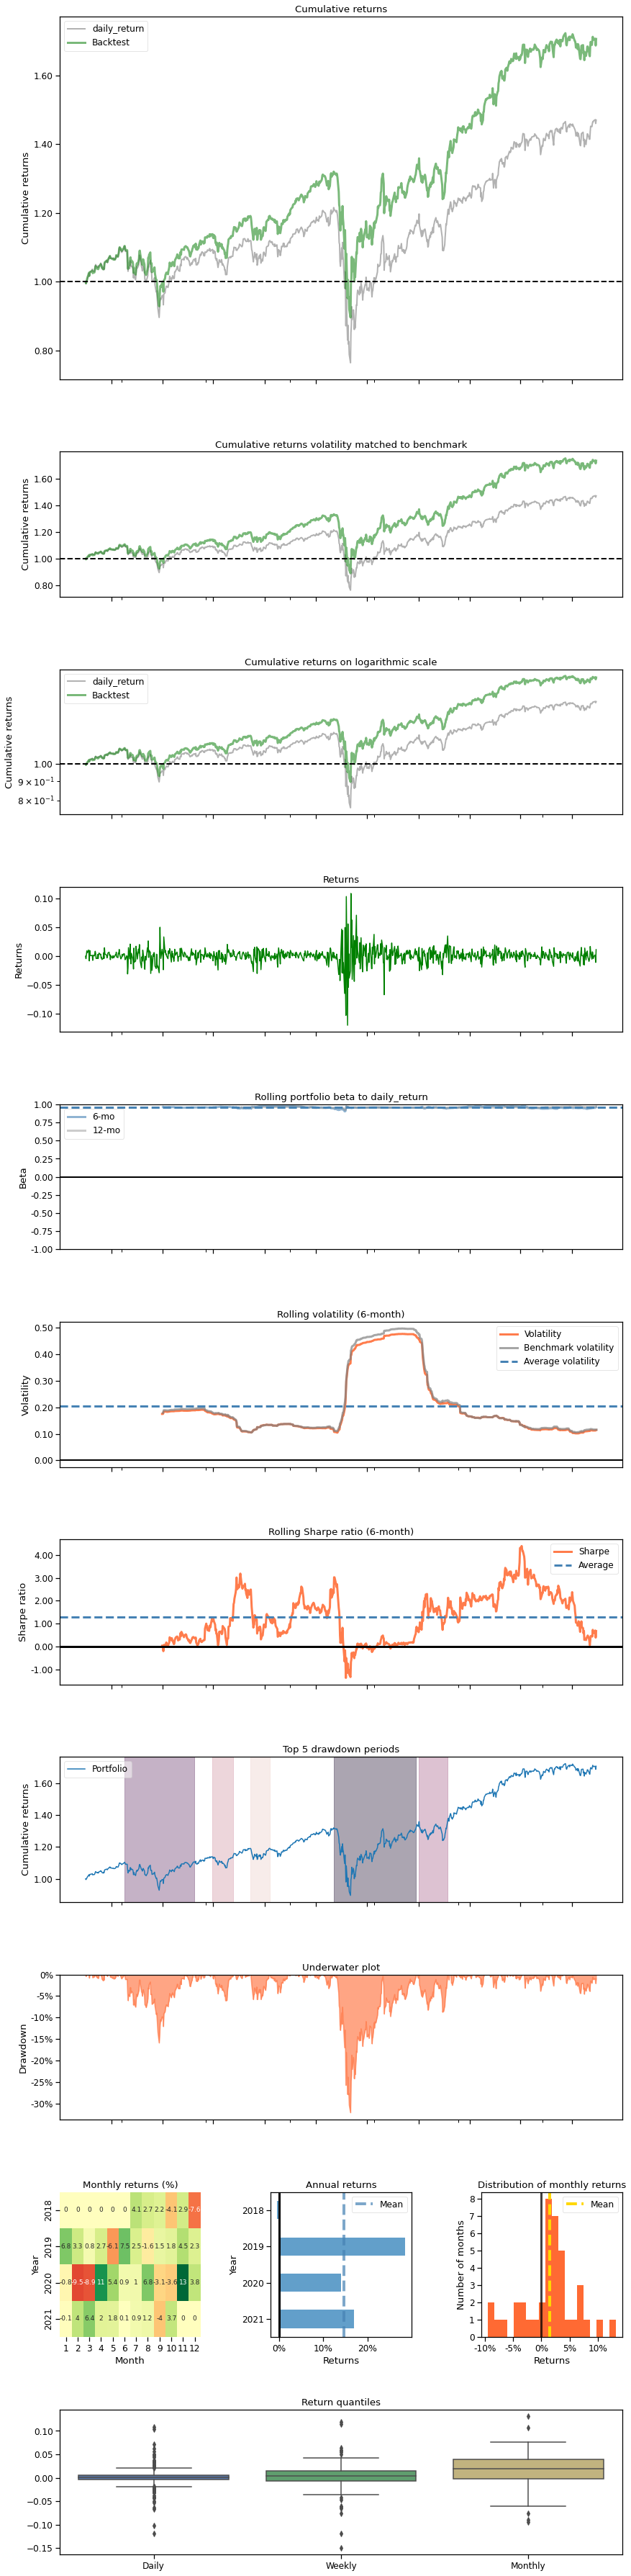

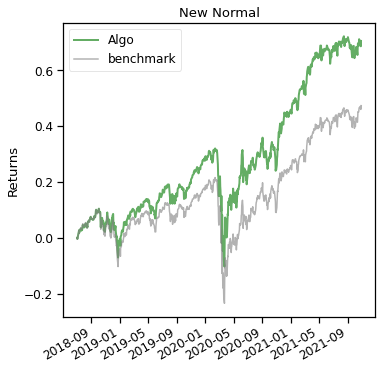

In [113]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
    ticker='^DJI',
    start=df_daily_return.loc[0, 'date'], end='2021-11-01'
)

baseline_returns = get_daily_return(baseline_df, value_col_name='close')

with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns=DRL_strat, benchmark_rets=baseline_returns, set_context=False)

### Prototyping of Technical Items
&emsp; -- action-state space in gym <br>
&emsp; -- weights sum contraint <br>

In [ ]:
# Action-State Space in Gym
from gym import spaces
state_space = len(df.tic.unique())
action_space = len(df.tic.unique())
action_space = spaces.Box(low=0, high=1, shape=(action_space,))
action_space.sample()

Box([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.], [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.], (29,), float32)

### Weights Sum Constraints

In [3]:
# Weights Sum Constraints
import numpy as np
test_bounds = (0, 1)
lower, upper = test_bounds
print(lower)
print(upper)

0
1


### Constraint over the Overall Market Exposition

In [41]:
n_assets = 20
_weights = [0.045]*n_assets + [-0.03]*n_assets
min_expo = 0
max_expo = 0.5
market_expo = sum(_weights)
print(market_expo)
# contraint convex set to 
market_expo >= min_expo and market_expo <= max_expo

0.2999999999999997


True

### Leverage

In [2]:
_weights = [0.045]*20 + [-0.03]*20 # weights simulation
leverage = sum([abs(x) for x in _weights]) # sum all absolute values of list items == sum all your positions (longs and shorts)
leverage

1.5000000000000007

#### Market Stats: <br>
&emsp; -- Longs and Shorts <br>
&emsp; -- Long Position and Short Position <br>
&emsp; -- Total Market Exposition <br>
&emsp; -- Overall Leverage <br>

In [110]:
class MarketStats():
    def __init__(self, weights:list):
        self.weights=weights
        self.weights_long = []
        self.weights_short = []
        self.longPosition = 0
        self.shortPosition = 0
        self.total_market_exposition = 0
        self.leverage = 0
        self.calculateStats()

    def calculateStats(self):
        [self.weights_long.append(x) for x in self.weights if x > 0]
        [self.weights_short.append(x) for x in self.weights if x < 0]
    
        self.longPosition = sum(self.weights_long), # Long Position   
        self.shortPosition = sum(self.weights_short), # Short Position
        self.total_market_exposition = sum(self.weights_long + self.weights_short) # Overall Market Exposition
        self.leverage = sum([abs(x) for x in self.weights])# Leverage: Sum all absolute values of list items == sum all your positions (longs and shorts)
    

    def printStats(self):
        print(f' -- Long Position:{self.longPosition} \n',
            f' -- Short Position: {self.shortPosition} \n',
            f' -- Total Market Expostion: {self.total_market_exposition} \n',
            f' -- Overall Leverage: {self.leverage} \n'
            )
        print(f' -- Longs: {self.weights_long} \n',
            f' -- Shorts: {[self.weights_short]} \n'
            )

# Example
portfolio = [0.045]*20 + [-0.03]*20 # 20 longs for 90% of portfolio and 20 shorts for 60% of portfolio (i.e. 1.5 leverage)
portfolioMetrics = MarketStats(weights=portfolio)
portfolioMetrics.printStats()

 -- Long Position:(0.9000000000000002,) 
  -- Short Position: (-0.6000000000000003,) 
  -- Total Market Expostion: 0.2999999999999997 
  -- Overall Leverage: 1.5000000000000007 

 -- Longs: [0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045] 
  -- Shorts: [[-0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03]] 



In [131]:
min_expo = 0.0
max_expo = 0.75
print(f'Total Exposition: {portfolioMetrics.total_market_exposition}')
portfolioMetrics.total_market_exposition >= min_expo and portfolioMetrics.total_market_exposition <= max_expo

Total Exposition: 0.2999999999999997


True

[1, 0, 1, -1, 1, 1, 0]

In [73]:
spaces.Discrete(3)*29

TypeError: unsupported operand type(s) for *: 'Discrete' and 'int'

#### Gym Spaces -- Playground

In [62]:
from gym import spaces
space = spaces.Discrete(30)
x = space.sample()
assert space.contains(x)
assert space.n == 30

In [27]:
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [29]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [33]:
env_kwargs = {
    "hmax": 100, # maximum stocks to buy/sell
    "initial_amount": 0.001,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
}

e_train_gym = StockTradingEnv(df=train, **env_kwargs)

In [34]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [37]:
agent = DRLAgent(env=env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [49]:
trained_a2c = agent.train_model(
                                model=model_a2c,
                                tb_log_name="a2c", 
                                total_timesteps=50000
                                )

-------------------------------------
| time/                 |           |
|    fps                | 134       |
|    iterations         | 100       |
|    time_elapsed       | 3         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -167      |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 7078      |
|    policy_loss        | -2.05e-05 |
|    reward             | 0.0       |
|    std                | 77.3      |
|    value_loss         | 1.24e-14  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 135      |
|    iterations         | 200      |
|    time_elapsed       | 7        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -169     |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates        

In [50]:
# Trading Evaluation
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [51]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [52]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [53]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.574230
std        43.787143
min         0.000000
25%        14.966086
50%        24.124643
75%        39.162481
max       652.504631
Name: turbulence, dtype: float64

In [54]:
insample_risk_indicator.turbulence.quantile(0.996)

276.4531972187886

In [55]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [56]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,90.036690,110737200.0,2.0,3.019033,92.835519,80.297756,62.807108,107.489533,29.730532,84.057088,77.831731,28.620001,53.068253
0,2020-07-01,AMGN,235.520004,256.230011,232.580002,242.083466,6575800.0,2.0,3.665608,234.264603,201.821547,61.279627,271.571279,46.806139,216.584933,217.666556,28.620001,53.068253
0,2020-07-01,AXP,95.250000,96.959999,93.639999,92.347763,3301000.0,2.0,-0.390268,110.737391,88.008447,48.504810,-66.334584,3.142448,97.520676,90.952974,28.620001,53.068253
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068253
0,2020-07-01,CAT,129.380005,129.399994,125.879997,121.230232,2807800.0,2.0,1.278732,131.250709,113.896731,52.865414,35.572238,14.457404,119.985500,114.191686,28.620001,53.068253


In [57]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

hit end!


In [58]:
df_account_value.shape

(336, 2)

In [59]:
df_account_value.tail()

,date,account_value
331,2021-10-22,0.001
332,2021-10-25,0.001
333,2021-10-26,0.001
334,2021-10-27,0.001
335,2021-10-28,0.001


In [60]:
df_actions.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-07-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-07-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-07-07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-07-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# Backtest
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.0
Cumulative returns     0.0
Annual volatility      0.0
Sharpe ratio           NaN
Calmar ratio           NaN
Stability              0.0
Max drawdown           0.0
Omega ratio            NaN
Sortino ratio          NaN
Skew                   NaN
Kurtosis               NaN
Tail ratio             NaN
Daily value at risk    0.0
dtype: float64


In [62]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (336, 8)
Annual return          0.269722
Cumulative returns     0.374922
Annual volatility      0.139083
Sharpe ratio           1.792302
Calmar ratio           3.020136
Stability              0.919220
Max drawdown          -0.089308
Omega ratio            1.347571
Sortino ratio          2.655481
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016534
dtype: float64


In [63]:
df_account_value.loc[0,'date']

'2020-07-01'

In [64]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-10-28'

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (336, 8)


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,0.0%
Cumulative returns,0.0%
Annual volatility,0.0%
Sharpe ratio,NaN
Calmar ratio,NaN
Stability,0.00
Max drawdown,0.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.00,2020-07-01,2020-07-01,2020-07-01,1
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


Stress Events,mean,min,max
New Normal,0.00%,0.00%,0.00%


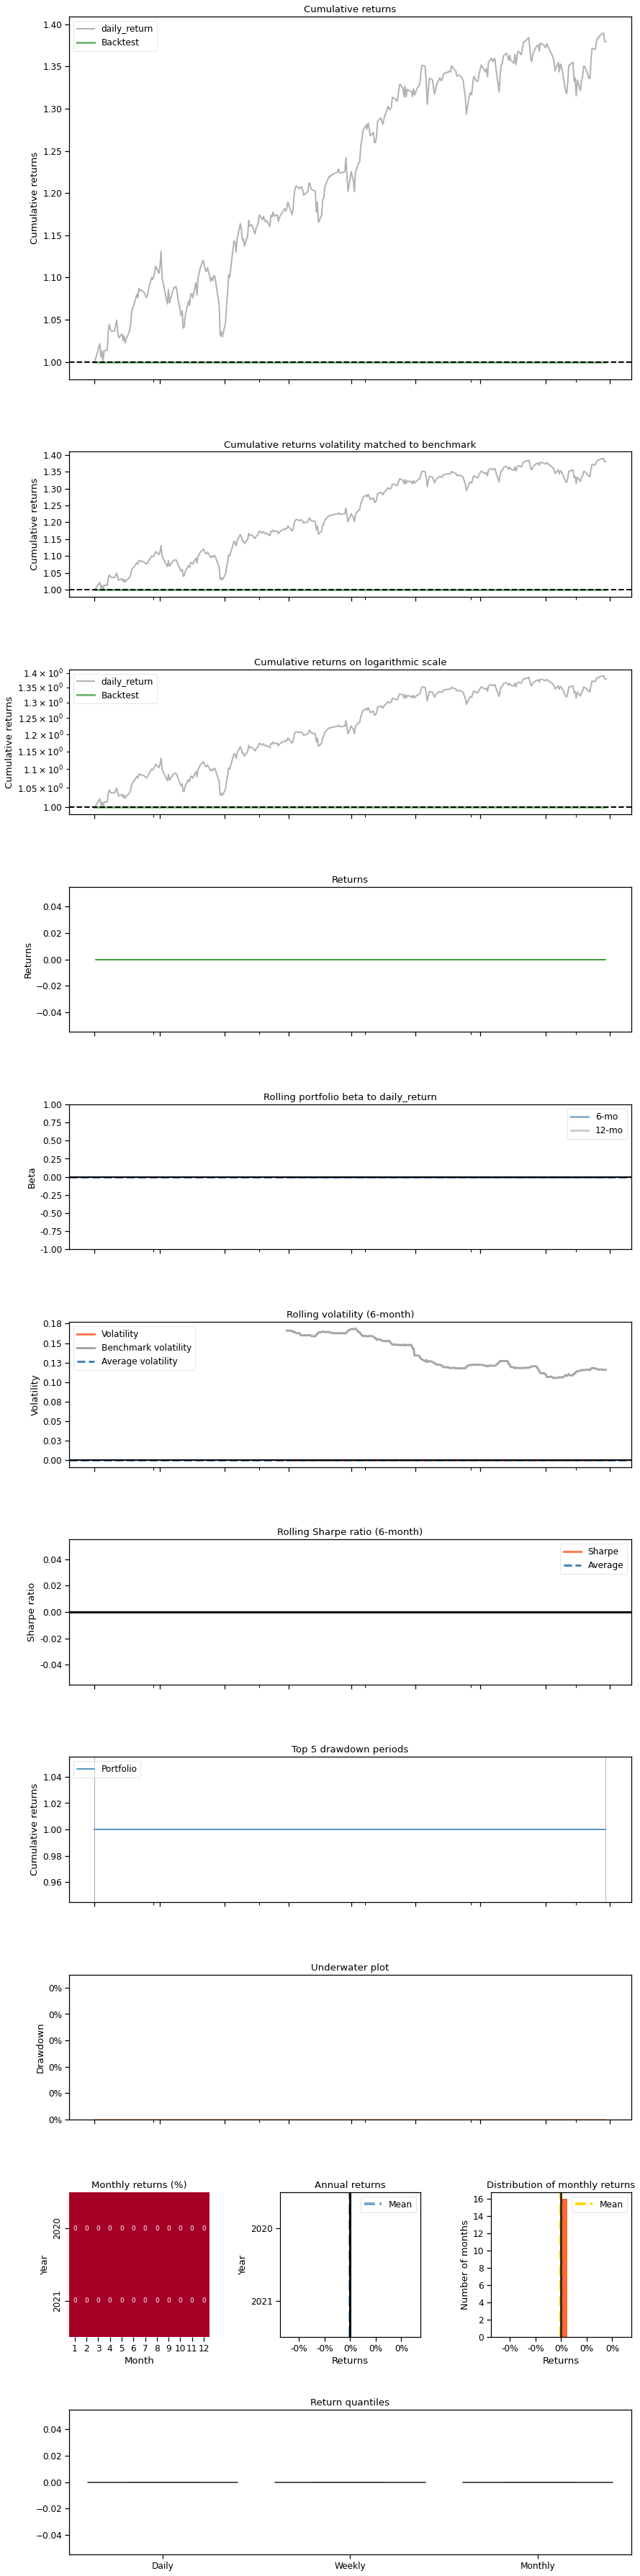

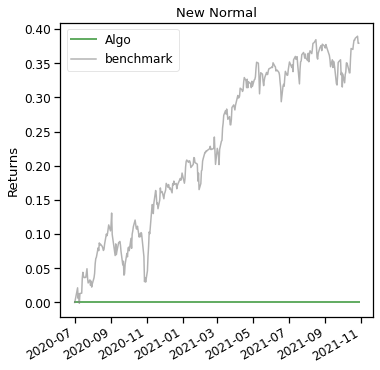

In [65]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])